<a href="https://colab.research.google.com/github/Cynthiaudoye/IMDB-Genre-Classification/blob/main/Keras_Assignment_Dec2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CW1 - Multimodal IMDB Analysis with Keras

## Introduction

In this assignment you will be provided a dataset containing a selection of films together with their posters in JPEG image format and their overviews in text format from the Internet Movie Database.

![Example](https://i.ibb.co/J3trT62/Screenshot-2024-09-22-214753.png)

You will be analysing this dataset by implementing and training two models: a **CNN** and an **LSTM**.

The CNN must classify film posters by the genre. Independently, the LSTM must classify film overviews by the genre. Finally, you will evaluate and critically comment your results in a short report. (Which of the two models was better at classifying films?)

## Structure of the assignment

This assignment is broken up into sections and you need to complete each section successively. The sections are the following:

1. Data Processing

  1.a. Image processing of the posters

  1.b. Natural language processing of the overviews

2. Definition of the models

  2.a. CNN for the posters

  2.b. LSTM for the overviews

3. Training of the models
4. Evaluation of the models

In addition to this coding exercise, you must write a **2-3 pages** report analysing and critically evaluating your model's results. Marks for the report will be awarded for depth of analysis and critical thinking skills. You should consider how well your model performs and WHY it does that—give specific examples and comment on their importance.

In [ ]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

In [ ]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Processing

Warning: running the following cell can take some time.


In [ ]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multimodal_IMDB_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multimodal_IMDB_dataset/Images /tmp/Multimodal_IMDB_dataset/


        191.65M 100%    1.10MB/s    0:02:45 (xfr#7896, to-chk=0/7897)


In [ ]:
# CodeGrade Tag Init3
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
dataset = pd.read_csv(csv_loc)

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Build the file locations for the images
img_loc = "/tmp/Multimodal_IMDB_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label


### 1.a. Image processing of the posters

In [ ]:
# CodeGrade Tag Init4
# Do not edit, remove, or copy this cell

# Create the initial datasets of film posters
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

* Create a function called ```img_process``` that converts the images to float32 datatype and resizes them to 64x64 pixels

In [ ]:
# CodeGrade Tag Ex1a-i
### Create a function called img_process that converts the images to
### float32 datatype and resizes them to 64x64 pixels

def img_process(image, label):

    # Convert image to float32 and normalize
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize images to 64x64
    image = tf.image.resize(image, [64, 64])

    return image, label

* **Using the ``tf.data`` API, load in the training and validation data for the posters. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [ ]:
# CodeGrade Tag Ex1a-ii
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64.

# Defining the batch size
batch_size = 64

# Training dataset
posters_train_ds = (
    list_posters_train_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(buffer_size=1000)
    .prefetch(tf.data.AUTOTUNE)
)

# Validation dataset
posters_valid_ds = (
    list_posters_valid_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


### 1.b. Natural Language processing of the overviews

In [ ]:
# CodeGrade Tag Init5
# Do not edit, remove, or copy this cell

# Create the initial datasets of the film overviews
list_overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train))
list_overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test))

* **Using the ``tf.data`` API, load in the training and validation data for the overviews.**

In [ ]:
# CodeGrade Tag Ex1b-i
### Construct the training and validation datasets. Use a batch size of 64.

# Defining the batch size
batch_size = 64

# Training dataset
overviews_train_ds = (
    list_overviews_train_ds
    .shuffle(buffer_size=1000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Training dataset
overviews_valid_ds = (
    list_overviews_valid_ds
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the film overviews train data.

In [ ]:
# CodeGrade Tag Ex1b-ii
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the film overviews train data.

VOCAB_SIZE = 10000

# Creating a TextVectorization layer for encoding
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=100
)

# Extracting only the text data for adaptation
encoder.adapt(overviews_train_ds.map(lambda overview, label: overview))

* Print the first 200 words of the vocabulary you obtained.

In [ ]:
# CodeGrade Tag Ex1b-iii
### Print the first 200 words of the vocabulary you obtained.

# Retrieving the vocabulary from the encoder
vocabulary = encoder.get_vocabulary()

# Printing the first 200 words
print(vocabulary[:200])

['', '[UNK]', 'a', 'the', 'to', 'of', 'and', 'in', 'his', 'is', 'an', 'with', 'her', 'for', 'on', 'he', 'who', 'their', 'by', 'when', 'from', 'as', 'that', 'after', 'young', 'life', 'they', 'him', 'new', 'man', 'two', 'at', 'but', 'are', 'has', 'into', 'up', 'she', 'woman', 'love', 'out', 'one', 'family', 'must', 'find', 'be', 'it', 'friends', 'finds', 'world', 'school', 'story', 'them', 'where', 'about', 'while', 'group', 'girl', 'years', 'lives', 'have', 'home', 'father', 'town', 'wife', 'help', 'becomes', 'war', 'city', 'three', 'back', 'get', 'during', 'boy', 'only', 'all', 'high', 'team', 'gets', 'son', 'himself', 'which', 'york', 'murder', 'against', 'between', 'american', 'other', 'time', 'small', 'police', 'former', 'can', 'its', 'down', 'mother', 'friend', 'will', 'falls', 'become', 'takes', 'own', 'being', 'daughter', 'before', 'tries', 'this', 'was', 'take', 'over', 'old', 'college', 'save', 'goes', 'set', 'death', 'through', 'agent', 'order', 'way', 'people', 'husband', 'fi

# 2. Definition of the models

### 2.a. CNN

**Using the Keras Functional API, create a convolutional neural network with the architecture shown in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [ ]:
# CodeGrade Tag Ex2a-i
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

def build_cnn_model():

  # Input layer
  inputs = Input(shape=(64, 64, 3), name="Input")

  # Conv0 -> ReLU activation
  x = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu", name="Conv0")(inputs)
  x = Dropout(0.2, name="Drop1")(x)

  # Conv1 -> Conv2 -> ReLU activation
  x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv1")(x)
  x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv2")(x)
  x = Dropout(0.2, name="Drop2")(x)

  # MaxPooling2D -> Pool1
  x = MaxPooling2D(pool_size=(2, 2), name="Pool1")(x)

  # Conv3 -> Conv4 -> ReLU activation
  x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv3")(x)
  x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv4")(x)
  x = Dropout(0.2, name="Drop3")(x)

  # MaxPooling2D -> Pool2
  x = MaxPooling2D(pool_size=(2, 2), name="Pool2")(x)

  # Conv5 -> Conv6 -> ReLU activation
  x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv5")(x)
  x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv6")(x)
  x = Dropout(0.2, name="Drop4")(x)

  # MaxPooling2D -> Pool3
  x = MaxPooling2D(pool_size=(2, 2), name="Pool3")(x)

  # Flatten
  x = Flatten(name="Flat")(x)

  # FC1 -> ReLU activation
  x = Dense(units=1024, activation="relu", name="FC1")(x)
  x = Dropout(0.5, name="Drop5")(x)

  # FC2 -> ReLU activation
  x = Dense(units=1024, activation="relu", name="FC2")(x)
  x = Dropout(0.5, name="Drop6")(x)

  # Output layer -> Sigmoid activation
  outputs = Dense(units=25, activation="sigmoid", name="Output")(x)

  # Creating the model
  model = Model(inputs=inputs, outputs=outputs, name="model")

  return model

cnn_model = build_cnn_model()


* Print the model summary and confirm it has the same architecture as the one provided.

In [ ]:
# CodeGrade Tag Ex2a-ii
### Print the model summary and confirm it has the same architecture as the one
### provided.

# Printing the model summary
cnn_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop2 (Dropout)                      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop3 (Dropout)                      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop4 (Dropout)                      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flat (Flatten)                       │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop5 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC2 (Dense)                          │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop6 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,464,601 (13.22 MB)

 Trainable params: 3,464,601 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [ ]:
# CodeGrade Tag Ex2a-iii
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[Precision(name="precision"),
             Recall(name="recall")]
    )


### 2.b. LSTM model

* Set up the embedding layer by using ```tf.keras.layers.Embedding```. The ```input_dim``` is the length of the vocab, and the ```output_dim``` must be **265**. You should also set ```mask_zero=True```.

In [ ]:
# CodeGrade Tag Ex2b-i
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 256. You should also set mask_zero=True.

embedder = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=256,
    mask_zero=True
)

* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:



  1.   encoder
  2.   embedder
  3.   biLSTM layer with 256 units, dropout 0.5, recurrent dropout 0.2 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   biLSTM layer with 128 units, dropout 0.5, recurrent dropout 0.2
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.8
  7.   dense output layer with 25 units and sigmoid activation function



In [ ]:
# CodeGrade Tag Ex2b-ii
### Build a keras sequential model, with the layers provided above.

lstm_model = tf.keras.Sequential([
    encoder,  # Encoder layer (text preprocessing)
    embedder,  # Embedding layer
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=256,
            dropout=0.5,
            recurrent_dropout=0.2,
            return_sequences=True
        )
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=128,
            dropout=0.5,
            recurrent_dropout=0.2
        )
    ),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(units=25, activation="sigmoid")
])

lstm_model.build((None,))

* Print the model summary and confirm is has the same architecture as the outline provided above.

In [ ]:
# CodeGrade Tag Ex2b-iii
### Print the model summary and confirm is has the same architecture as the
### outline provided above.

# Printing the LSTM model summary
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 100)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 512)            │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,303,129 (16.42 MB)

 Trainable params: 4,303,129 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

* Compile the model with binary crossentropy loss and the adam optimizer. For the metrics, use the Precision and Recall functions.

In [ ]:
# CodeGrade Tag Ex2b-iv
### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

lstm_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[Precision(name="precision"),
             Recall(name="recall")]
    )


# 3. Training of the models

* **For each model, create a Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [ ]:
# CodeGrade Tag Ex3a-i
### Create two ModelCheckpoint callbacks to store the bext weights from each
### model, both based on the validation loss.

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cnn_callback = ModelCheckpoint(
    filepath=checkpoint_cnn_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    verbose=1
)

checkpoint_lstm_callback = ModelCheckpoint(
    filepath=checkpoint_lstm_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    verbose=1
)



* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:
# CodeGrade Tag Ex3a-ii
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

# Correct import for LearningRateScheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler, verbose=1)


### 3.a. CNN training

* **Train the CNN model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3a-iii
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

cnn_history = cnn_model.fit(
    posters_train_ds,
    validation_data=posters_valid_ds,
    epochs=40,
    callbacks=[checkpoint_cnn_callback,
               lr_callback],
    verbose=1
    )



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/40
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.4400 - precision: 0.2364 - recall: 0.2693
Epoch 1: val_loss improved from inf to 0.33284, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - loss: 0.4372 - precision: 0.2386 - recall: 0.2686 - val_loss: 0.3328 - val_precision: 0.5407 - val_recall: 0.2244 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/40
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2547 - precision: 0.4862 - recall: 0.2120
Epoch 2: val_loss improved from 0.33284 to 0.32912, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2546 - precision: 0.4865 - recall: 0.2121 - val_loss: 0.3291 - val_precision: 0.5407 - val_recall: 0.2244 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.9999

* **Train the model for 20 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3b-i
# Train the model for 20 epochs.
lstm_history = lstm_model.fit(
    overviews_train_ds,
    validation_data=overviews_valid_ds,
    epochs=20,
    callbacks=[checkpoint_lstm_callback,
               lr_callback],
    verbose=1
                    )



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6687 - precision: 0.1140 - recall: 0.4460
Epoch 1: val_loss improved from inf to 0.38865, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - loss: 0.6681 - precision: 0.1142 - recall: 0.4453 - val_loss: 0.3887 - val_precision: 0.5407 - val_recall: 0.2244 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4864 - precision: 0.1626 - recall: 0.3285
Epoch 2: val_loss improved from 0.38865 to 0.31702, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - loss: 0.4862 - precision: 0.1628 - recall: 0.3285 - val_loss: 0.3170 - val_precision: 0.5407 - val_recall: 0.2244 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.9999997

# 4. Evaluation of the models

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

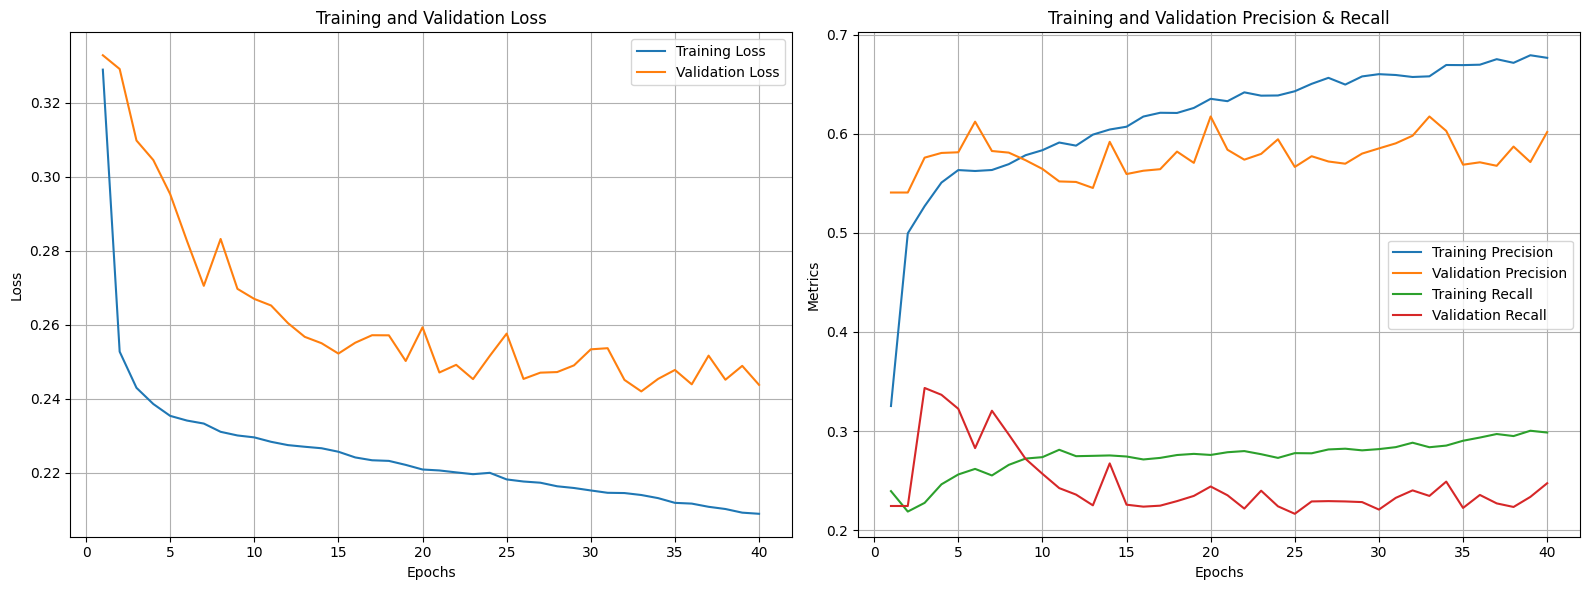

In [ ]:
# CodeGrade Tag Ex4a-i

# Extracting training and validation metrics
train_loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
precision = cnn_history.history['precision']
val_precision = cnn_history.history['val_precision']
recall = cnn_history.history['recall']
val_recall = cnn_history.history['val_recall']
epochs = range(1, len(train_loss) + 1)

# Creating a horizontal layout for the plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Loss
axs[0].plot(epochs, train_loss, label="Training Loss")
axs[0].plot(epochs, val_loss, label="Validation Loss")
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# Plotting the precision and recall
axs[1].plot(epochs, precision, label="Training Precision")
axs[1].plot(epochs, val_precision, label="Validation Precision")
axs[1].plot(epochs, recall, label="Training Recall")
axs[1].plot(epochs, val_recall, label="Validation Recall")
axs[1].set_title("Training and Validation Precision & Recall")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Metrics")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 0.2310 - precision: 0.6139 - recall: 0.2728
LSTM Model Evaluation:
Loss: 0.22940465807914734
Precision: 0.6093294620513916
Recall: 0.2742782235145569


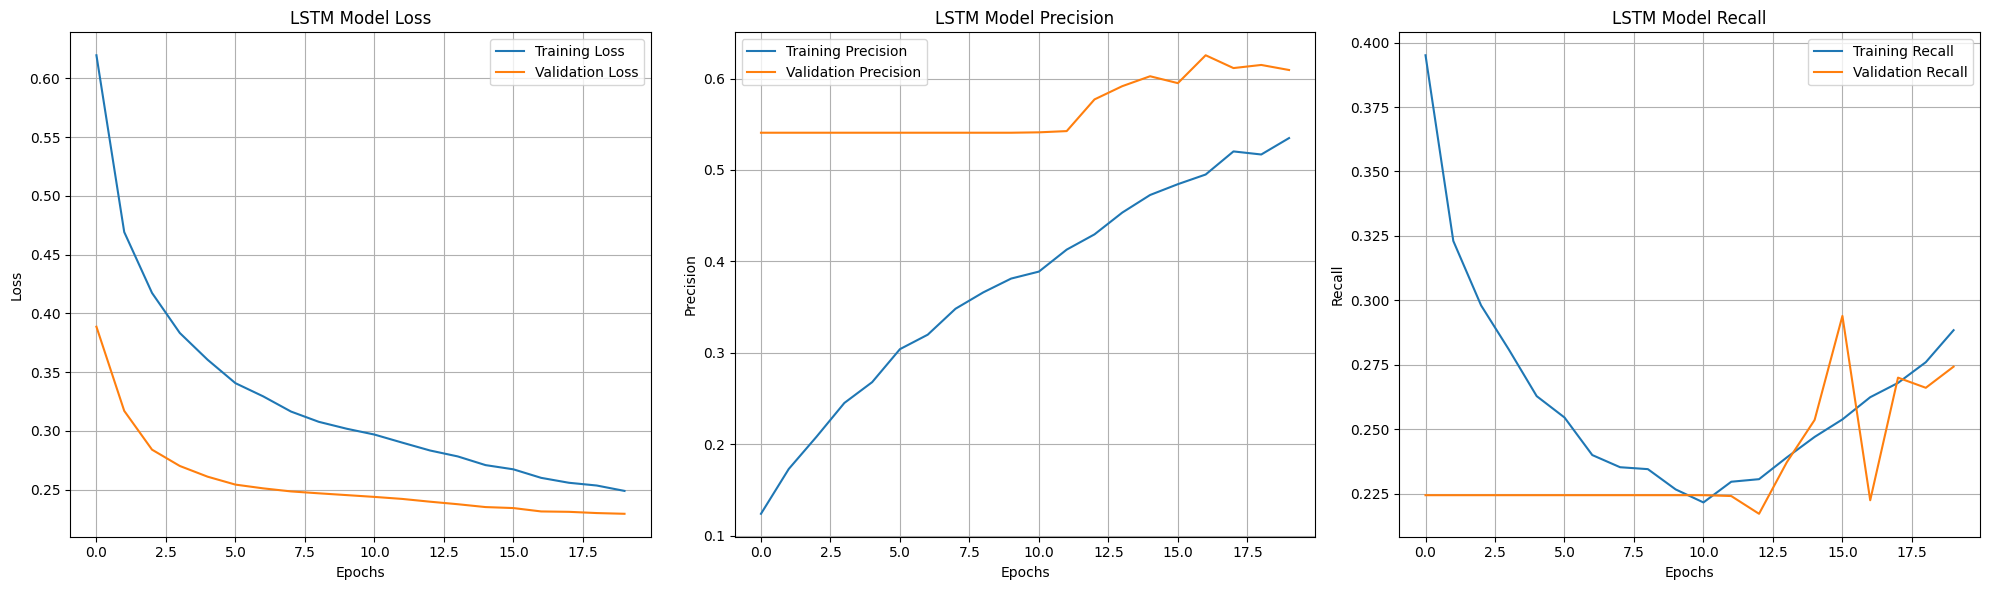


Critical Evaluation:
- Loss shows how well the model fits the training data, and low values suggest good optimization.
- Precision indicates the model's ability to avoid false positives, while Recall indicates its ability to detect true positives.
- These metrics should be analyzed together to determine if the model is underperforming for specific genres.
- Additionally, the dataset's imbalance may affect these results, as some genres may be poorly represented.



In [ ]:
# CodeGrade Tag Ex4b-i

# Load the best weights from the checkpoint
lstm_model.load_weights(checkpoint_lstm_filepath)

# Evaluate the model on the test set
lstm_evaluation = lstm_model.evaluate(overviews_valid_ds, verbose=1)

# Extracting metrics for evaluation
loss, precision, recall = lstm_evaluation

print(f"LSTM Model Evaluation:")
print(f"Loss: {loss}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Creating subplots for Loss, Precision, and Recall
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plotting training and validation losses
axs[0].plot(lstm_history.history['loss'], label='Training Loss')
axs[0].plot(lstm_history.history['val_loss'], label='Validation Loss')
axs[0].set_title('LSTM Model Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plotting training and validation precision
axs[1].plot(lstm_history.history['precision'], label='Training Precision')
axs[1].plot(lstm_history.history['val_precision'], label='Validation Precision')
axs[1].set_title('LSTM Model Precision')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Precision')
axs[1].legend()
axs[1].grid()

# Plotting training and validation recall
axs[2].plot(lstm_history.history['recall'], label='Training Recall')
axs[2].plot(lstm_history.history['val_recall'], label='Validation Recall')
axs[2].set_title('LSTM Model Recall')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Recall')
axs[2].legend()
axs[2].grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Critical evaluation
print("""
Critical Evaluation:
- Loss shows how well the model fits the training data, and low values suggest good optimization.
- Precision indicates the model's ability to avoid false positives, while Recall indicates its ability to detect true positives.
- These metrics should be analyzed together to determine if the model is underperforming for specific genres.
- Additionally, the dataset's imbalance may affect these results, as some genres may be poorly represented.
""")

### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few films from the dataset, plot their posters and print their overviews. Use these example films to demonstrate the classification performance of the CNN model on their posters and of the LSTM model on their overview.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example film, the top three most probable genres predicted by the CNN and the top three most probable genres predicted by the LSTM with the ground truth genres.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


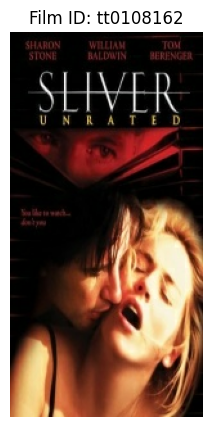

Overview:
A woman moves into an exclusive New York City apartment building, which she soon discovers houses tenants with all manner of shocking secrets.

Ground Truth Genres: ['Comedy', 'Romance']
Top 3 CNN Predictions: [('Drama', 0.535177), ('Thriller', 0.41146564), ('Crime', 0.3190197)]
Top 3 LSTM Predictions: [('Drama', 0.57104003), ('Comedy', 0.44596103), ('Romance', 0.20220152)]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


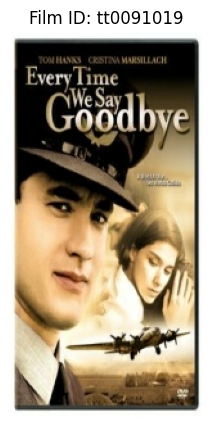

Overview:
A Protestant World War II pilot and a Jewish girl fall in love in Jerusalem, even though their diverse backgrounds threaten to pull them apart.

Ground Truth Genres: ['Comedy', 'Crime', 'Drama']
Top 3 CNN Predictions: [('Drama', 0.7104481), ('Romance', 0.35832384), ('Thriller', 0.28619272)]
Top 3 LSTM Predictions: [('Drama', 0.7284702), ('Comedy', 0.6159663), ('Romance', 0.31404954)]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


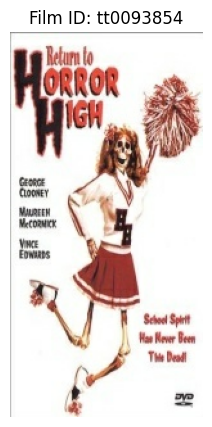

Overview:
A few years ago, a mysterious serial-killer caused panic on Crippen High School. The killer was never caught. A movie company, Cosmic Pictures, has decided to make a feature movie about ...

Ground Truth Genres: ['Comedy', 'Drama', 'Romance']
Top 3 CNN Predictions: [('Drama', 0.65049964), ('Comedy', 0.48447198), ('Romance', 0.42725855)]
Top 3 LSTM Predictions: [('Drama', 0.58391047), ('Comedy', 0.4360947), ('Romance', 0.17776717)]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


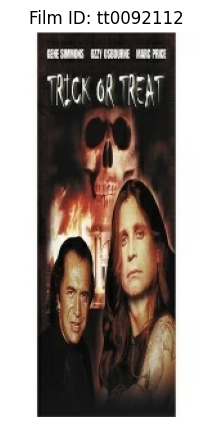

Overview:
A bullied teenage boy is devastated after the death of his heavy metal idol, Sammi Curr. But as Hallowe'en night approaches, he discovers that he may be the only one who can stop Sammi from making a Satanic comeback from beyond the grave.

Ground Truth Genres: ['Comedy', 'Drama', 'Music']
Top 3 CNN Predictions: [('Drama', 0.7518147), ('Romance', 0.3605625), ('Comedy', 0.24803013)]
Top 3 LSTM Predictions: [('Drama', 0.42050254), ('Comedy', 0.31557244), ('Action', 0.29273906)]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


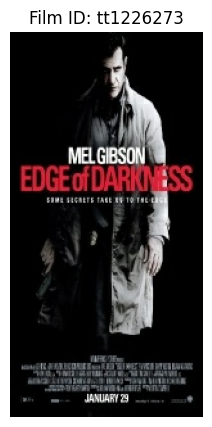

Overview:
As homicide detective Thomas Craven investigates the murder of his activist daughter, he uncovers a corporate cover-up and government conspiracy that attracts an agent tasked with cleaning up the evidence.

Ground Truth Genres: ['Action', 'Adventure', 'Thriller']
Top 3 CNN Predictions: [('Drama', 0.38861257), ('Horror', 0.36215693), ('Action', 0.36139753)]
Top 3 LSTM Predictions: [('Drama', 0.48702192), ('Comedy', 0.37449005), ('Action', 0.23257138)]
--------------------------------------------------


In [ ]:
# CodeGrade Tag Ex4c

import random

# Load the best weights for both CNN and LSTM models
cnn_model.load_weights(checkpoint_cnn_filepath)
lstm_model.load_weights(checkpoint_lstm_filepath)

# Select a few random films from the test dataset
sample_indices = random.sample(range(len(data_test)), 5)
sample_data = data_test.iloc[sample_indices].reset_index(drop=True)

# Function to get top 3 most probable genres
def get_top_3_predictions(predictions, genres):
    sorted_indices = predictions.argsort()[-3:][::-1]  # Indices of top 3 predictions
    top_genres = [(genres[i], predictions[i]) for i in sorted_indices]
    return top_genres

# Iterate over the selected examples
for idx, row in sample_data.iterrows():
    img_path = os.path.join(img_loc, f"{row['Id']}.jpg")
    overview = row['Overview']
    ground_truth = [genres[i] for i, label in enumerate(labels_test[idx]) if label == 1]

    # Load and preprocess the poster image for CNN
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img)
    img_processed = tf.image.convert_image_dtype(img, tf.float32)
    img_processed = tf.image.resize(img_processed, [64, 64])
    img_processed = tf.expand_dims(img_processed, axis=0)  # Add batch dimension

    # Predict with CNN
    cnn_predictions = cnn_model.predict(img_processed)[0]
    cnn_top_3 = get_top_3_predictions(cnn_predictions, genres)

    # Preprocess the overview for LSTM
    overview_processed = tf.constant([overview])  # Add batch dimension

    # Predict with LSTM
    lstm_predictions = lstm_model.predict(overview_processed)[0]
    lstm_top_3 = get_top_3_predictions(lstm_predictions, genres)

    # Plot the poster and print the overview
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Film ID: {row['Id']}")
    plt.show()

    print(f"Overview:\n{overview}\n")
    print(f"Ground Truth Genres: {ground_truth}")
    print(f"Top 3 CNN Predictions: {cnn_top_3}")
    print(f"Top 3 LSTM Predictions: {lstm_top_3}")
    print("-" * 50)
